In [1]:
EPOCH_NUMBER = 100
LEARNING_RATE = 0.001
TENSOR_SIZE = 128
BATCH_SIZE = 32
dropout_rate = 0.8

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

dataset_path = './Micro_Organism'

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter

transform = Compose([
    Resize((TENSOR_SIZE, TENSOR_SIZE)),
    ToTensor(),
    RandomRotation(degrees=30), # new here
    RandomHorizontalFlip(), # new here
    RandomVerticalFlip(), # new here
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # new here
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)

import torch
from torch.utils.data import random_split

torch.manual_seed(42)
train_size = 400
val_size = 160
test_size = len(dataset) - (train_size + val_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

def count_labels(dataset_subset, dataset_targets, num_classes):
    indices = dataset_subset.indices
    labels = [dataset_targets[i] for i in indices]
    counts = [labels.count(i) for i in range(num_classes)]
    return counts

num_classes = 8

labels = dataset.targets

train_counts = count_labels(train_dataset, labels, num_classes)
val_counts = count_labels(validation_dataset, labels, num_classes)
test_counts = count_labels(test_dataset, labels, num_classes)

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)
print("Test set class distribution:", test_counts)

Training set class distribution: [33, 82, 33, 78, 47, 46, 42, 39]
Validation set class distribution: [15, 32, 10, 35, 17, 17, 18, 16]
Test set class distribution: [24, 54, 33, 39, 21, 23, 15, 20]


In [3]:
from torch.utils.data.dataloader import DataLoader

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size * 2, num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size * 2, num_workers = 4, pin_memory = True)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    # Generate predictions
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc} 

  def validation_epoch_end(self, outputs):
      batch_losses = [x['validation_loss'] for x in outputs]
      # Combine losses
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['validation_accuracy'] for x in outputs]
      # Combine accuracies
      epoch_acc = torch.stack(batch_accs).mean()
      return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      train_loss, val_loss, val_acc = result['train_loss'], result['validation_loss'], result['validation_accuracy']
      print(f"Epoch [{epoch}/{EPOCH_NUMBER}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

**Adding Residual Connection**

1. The **residual block** consists of the second convolutional layer **`(conv4)`** and its activation function **`(relu4)`**.

In [5]:
class CNNModelResidual(ImageClassificationModel):
    def __init__(self):
        super(CNNModelResidual, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(dropout_rate)

        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        self.connected1 = nn.Linear(128 * int(TENSOR_SIZE / 2) * int(TENSOR_SIZE / 2), 8)
        
    def forward(self, value):
        # First Conv
        out = self.conv1(value)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.pool(out)

        # Second Conv
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Third Conv
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        # Fourth Conv
        res4 = out
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = out + res4  # Residual connection

        # Fifth Conv
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.dropout5(out)

        # Sixth Conv
        out = self.conv6(out)
        out = self.relu6(out)
        out = self.dropout6(out)

        ## Fully Connected Layers
        out = self.flatten(out)
        out = self.connected1(out)

        return out


model = CNNModelResidual()
model

CNNModelResidual(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (dropout1): Dropout(p=0.8, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (dropout2): Dropout(p=0.8, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (dropout3): Dropout(p=0.8, inplace=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (dropout4): Dropout(p=0.8, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (dropout5): Dropout(p=0.8, inplace=False)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (dropout6): Dropout(p=0.8, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (connected1):

In [6]:
def get_default_device():
    if torch.cuda.is_available():
        print('Using CUDA')
        return torch.device('cuda')
    else:
        print('Using CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataloader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
device

Using CUDA


device(type='cuda')

In [7]:
train_dataloader = DeviceDataloader(train_dataloader,  device)
validation_dataloader = DeviceDataloader(validation_dataloader, device)
test_dataloader = DeviceDataloader(test_dataloader, device)

In [8]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
evaluate(model, validation_dataloader)

{'validation_loss': 2.0882840156555176,
 'validation_accuracy': 0.0572916679084301}

In [9]:
num_epochs = EPOCH_NUMBER
opt_func = torch.optim.Adam
lr = LEARNING_RATE

In [10]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func=opt_func)

Epoch [0/100], Training Loss: 6.2770, Validation Loss: 2.0846, Validation Accuracy: 0.0573
Epoch [1/100], Training Loss: 2.0838, Validation Loss: 2.0806, Validation Accuracy: 0.0573
Epoch [2/100], Training Loss: 2.0785, Validation Loss: 2.0756, Validation Accuracy: 0.2031
Epoch [3/100], Training Loss: 2.0749, Validation Loss: 2.0710, Validation Accuracy: 0.2031
Epoch [4/100], Training Loss: 2.0720, Validation Loss: 2.0665, Validation Accuracy: 0.2031
Epoch [5/100], Training Loss: 2.0647, Validation Loss: 2.0625, Validation Accuracy: 0.2031
Epoch [6/100], Training Loss: 2.0626, Validation Loss: 2.0583, Validation Accuracy: 0.2031
Epoch [7/100], Training Loss: 2.0575, Validation Loss: 2.0541, Validation Accuracy: 0.2031
Epoch [8/100], Training Loss: 2.0582, Validation Loss: 2.0500, Validation Accuracy: 0.2031
Epoch [9/100], Training Loss: 2.0506, Validation Loss: 2.0462, Validation Accuracy: 0.2031
Epoch [10/100], Training Loss: 2.0511, Validation Loss: 2.0426, Validation Accuracy: 0.203

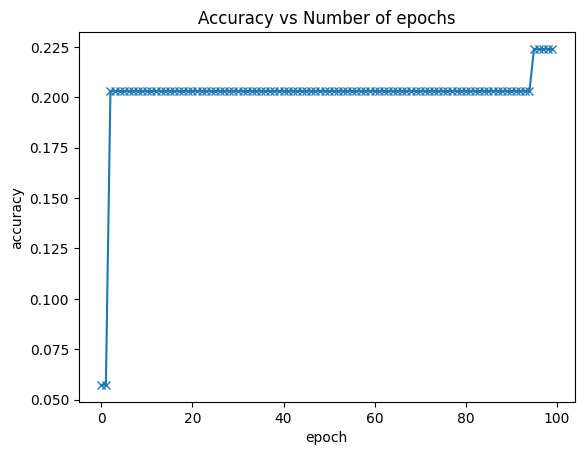

In [11]:
def plot_accuracies(history):
    accuracies = [x['validation_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Number of epochs')

plot_accuracies(history)

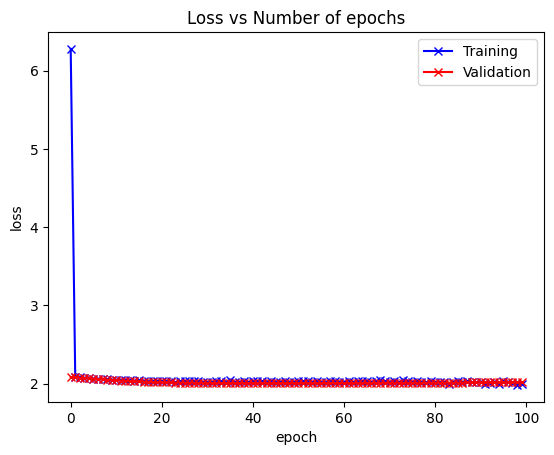

In [12]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Number of epochs')

plot_losses(history)

The dropout rate `0.8` does not fix the overfitting problem.

In [13]:
evaluate(model, test_dataloader)

{'validation_loss': 2.0390145778656006,
 'validation_accuracy': 0.1865498274564743}

**Test Accuracy**: 18%

In [14]:
torch.save(model.state_dict(), 'dropout7_4.pth')